# <center>Bank Marketing (Campaign)</center>

Group Name: __Bank Marketing DS 01__

Specialization: __Data Science__

Team Members: 
1. __Ines Perko__
2. __Suvansh Vaid__
3. __Zeynep Basask Elen__

# Data Cleaning and Transformation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Reading data
data = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Numerical variables
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# Exploring categorical variables
for col in data.select_dtypes(include='object').columns:
    print(col)
    print(data[col].unique())

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital
['married' 'single' 'divorced' 'unknown']
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default
['no' 'unknown' 'yes']
housing
['no' 'yes' 'unknown']
loan
['no' 'yes' 'unknown']
contact
['telephone' 'cellular']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
poutcome
['nonexistent' 'failure' 'success']
y
['no' 'yes']


In [6]:
# storing categorical data
categorical_features=[feature for feature in data.columns if ((data[feature].dtypes=='O') &
                                                            (feature not in ['y']))]

In [7]:
# storing numerical features
numerical_features = [x for x in data.columns if (x not in categorical_features) & (x != 'y')]

## Finding missing values

In [9]:
# Finding missing values
features_na = [features for features in data.columns if data[features].isnull().sum() > 0]
for feature in features_na:
    print(feature, np.round(data[feature].isnull().mean(), 4),  ' % missing values')
else:
    print("No missing value found")

No missing value found


## Detecting Outliers

First, analyzing the boxplot of all the numerical variables to identify any potential outliers.

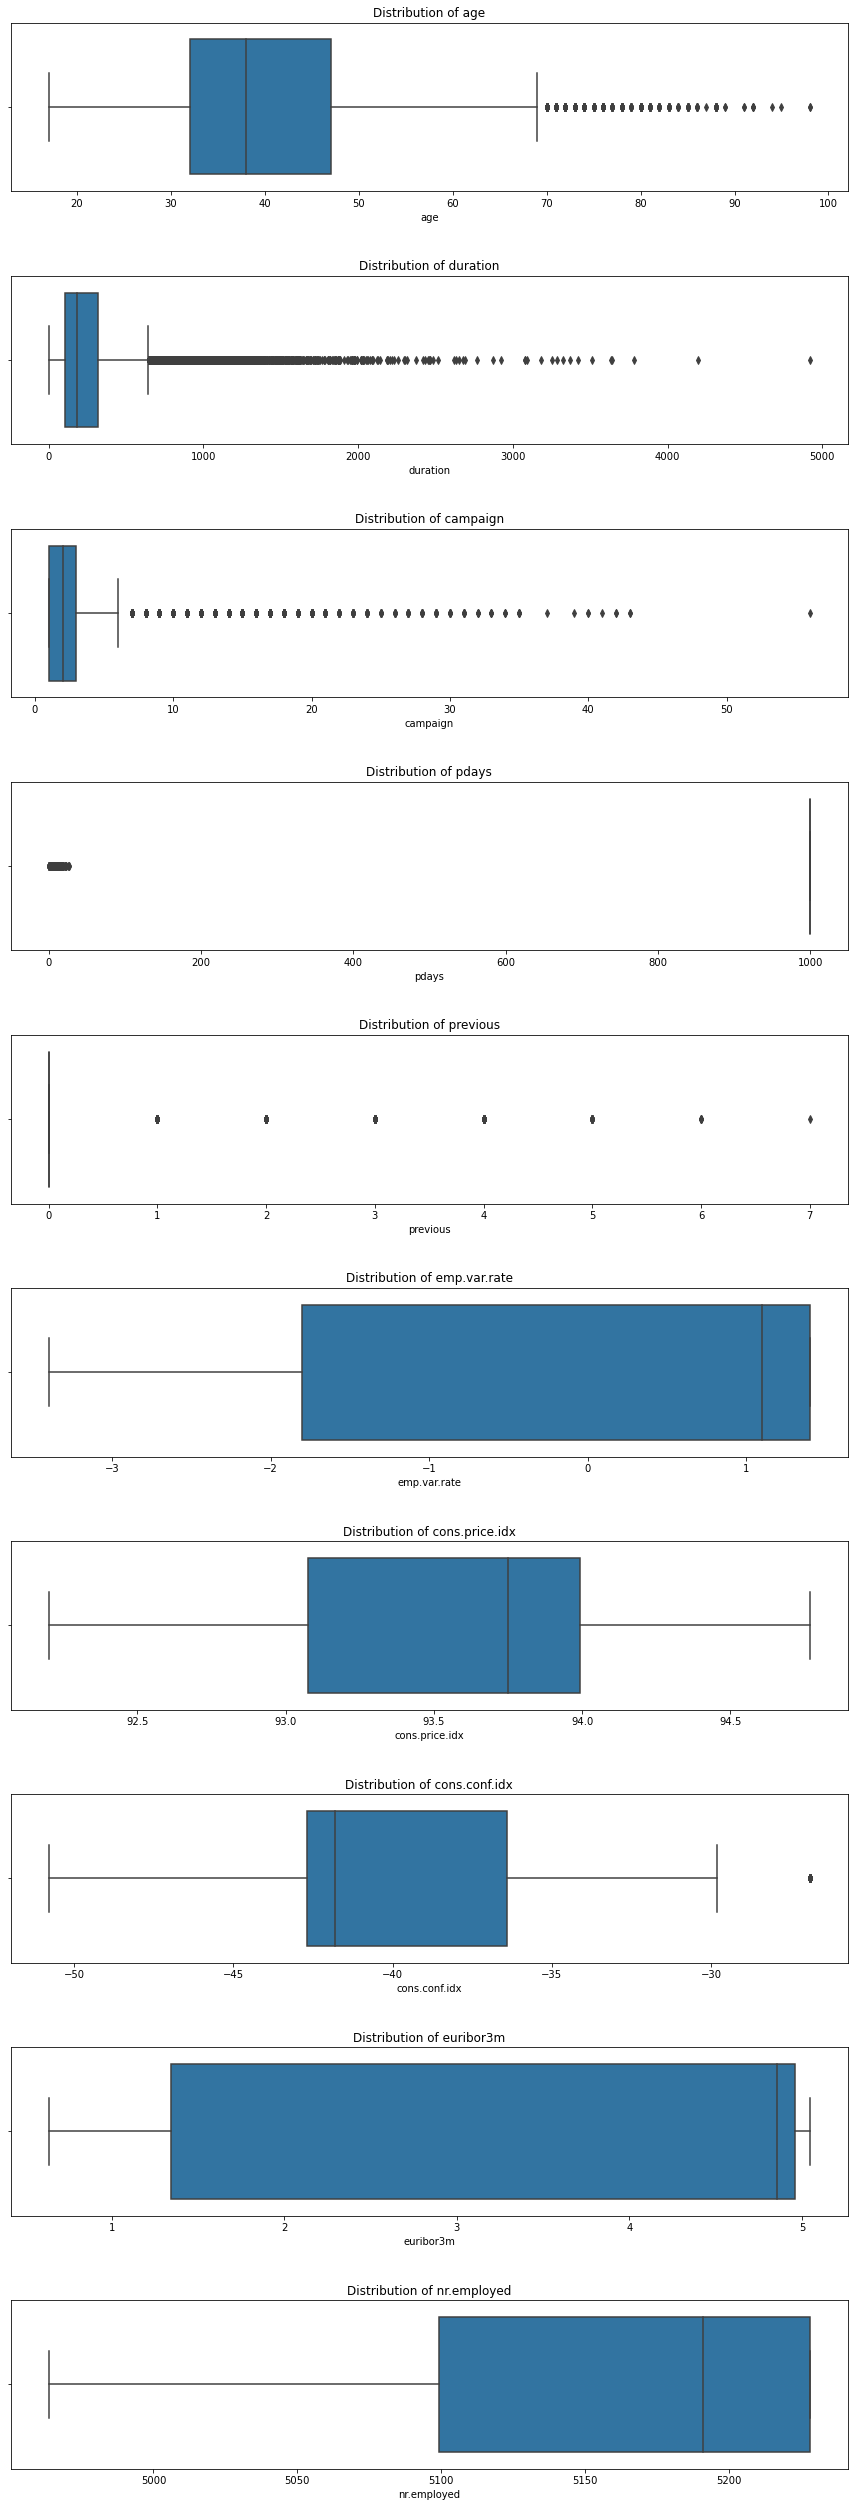

In [10]:
# distribution of numerical attributes

fig, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(15, 45)) # create subplots
fig.subplots_adjust(hspace=.5) # adjust space between plots

for i, col in enumerate(numerical_features):
    sns.boxplot(x=data[col], ax=ax[i])
    ax[i].set_title('Distribution of {}'.format(col))

So according to the boxplots above, the following variables are expected to have potential outliers:
`age`, `balance`, `duration`, `pdays`, `previous`, `campaign`. The Hampel correction rule is used here to identify outlier data.

Methodology:
We used the following three approaches to detect the outliers. 

1. 3 Sigma rule 
2. Boxplot rule 
3. Hampel correction

In [32]:
def three_sigma(col_name):
    
    stat = data[col_name].describe()
    
    #The median absolute deviation(MAD) scale estimator S = 1.4826 * median

    #standard deviation
    sd = stat['std']

    # mean
    mean = stat['mean']
    
    median = stat['median']

    # finding outliers using the 3 sd rule
    idx = data[abs(data[col_name] - mean) > 3 * sd].index

    return(idx, median)

In [33]:
def boxplot_outlier(col_name):
    
    # Using the IQR rule to identify outlier data.
    # if a data point is below Q1 – 1.5×IQR or above Q3 + 1.5×IQR, it is an outlier. 

    # getting the statistical summary 
    stat = data[col_name].describe()

    # First quartile
    Q1 = stat ['25%']

    # 3rd quartile
    Q3 = stat ['75%']

    # inter quartile range
    IQR = Q3 - Q1

    min_limit = Q1 - 1.5 * IQR

    max_limit = Q3 + 1.5 * IQR
    
    mean = stat['mean']

    # finding outliers using the iqr boxplot rule
    idx = data[(data[col_name] < min_limit) | (data[col_name] > max_limit)].index
    
    return(idx, mean)

In [34]:
def hampel_correction(col_name):
    
    stat = data[col_name].describe()
    
    #The median absolute deviation(MAD) scale estimator S = 1.4826 * median

    # median
    median = stat['50%']

    # mean absolute deviation
    S = 1.4826 * median

    # finding outliers using the hampel rule
    idx = data[abs(data[col_name] - median) > 3 * S].index
    
    mean = stat['mean']

    return(idx, mean)

### Finding outliers (using the above 3 methods)

In [28]:
for col in numerical_features:
    print('The number of outliers detected for ',col,' = ', len(three_sigma(col)[0]))    

The number of outliers detected for  age  =  369
The number of outliers detected for  duration  =  861
The number of outliers detected for  campaign  =  869
The number of outliers detected for  pdays  =  1515
The number of outliers detected for  previous  =  1064
The number of outliers detected for  emp.var.rate  =  0
The number of outliers detected for  cons.price.idx  =  0
The number of outliers detected for  cons.conf.idx  =  0
The number of outliers detected for  euribor3m  =  0
The number of outliers detected for  nr.employed  =  0


In [29]:
for col in numerical_features:
    print('The number of outliers detected for ',col,' = ', len(boxplot_outlier(col)[0]))    

The number of outliers detected for  age  =  469
The number of outliers detected for  duration  =  2963
The number of outliers detected for  campaign  =  2406
The number of outliers detected for  pdays  =  1515
The number of outliers detected for  previous  =  5625
The number of outliers detected for  emp.var.rate  =  0
The number of outliers detected for  cons.price.idx  =  0
The number of outliers detected for  cons.conf.idx  =  447
The number of outliers detected for  euribor3m  =  0
The number of outliers detected for  nr.employed  =  0


In [30]:
for col in numerical_features:
    print('The number of outliers detected for ',col,' = ', len(hampel_correction(col)[0]))    

The number of outliers detected for  age  =  0
The number of outliers detected for  duration  =  1018
The number of outliers detected for  campaign  =  869
The number of outliers detected for  pdays  =  0
The number of outliers detected for  previous  =  5625
The number of outliers detected for  emp.var.rate  =  0
The number of outliers detected for  cons.price.idx  =  0
The number of outliers detected for  cons.conf.idx  =  41188
The number of outliers detected for  euribor3m  =  0
The number of outliers detected for  nr.employed  =  0


Out of the 3 above methods, the __3 sigma rule__ seems to give us the best results. Thus, replacing the outlers with the median. 

In [35]:
for col in numerical_features:
    
    idx, median = hampel_correction(col)[0], hampel_correction(col)[1]
    
    data.loc[idx, col] = median    

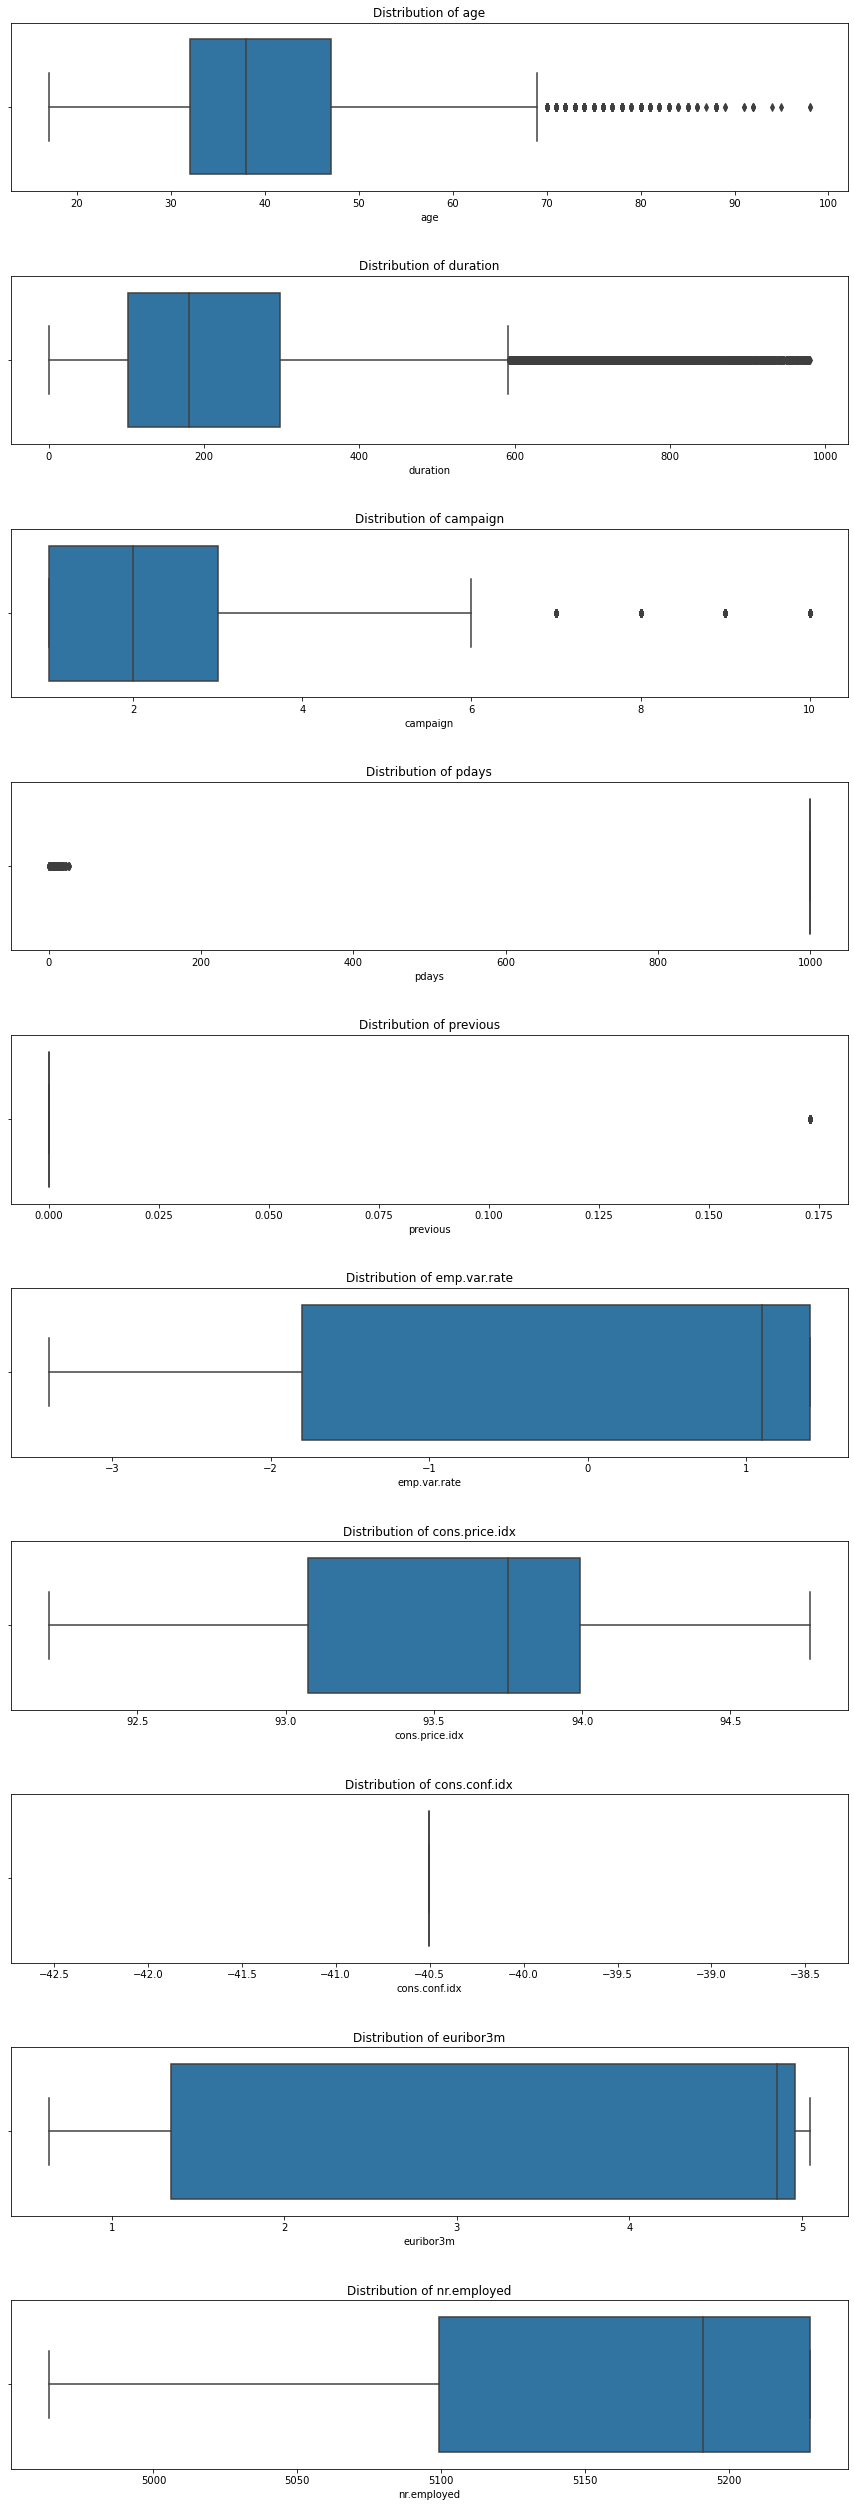

In [36]:
# distribution of numerical attributes after outlier replacement

fig, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(15, 45)) # create subplots
fig.subplots_adjust(hspace=.5) # adjust space between plots

for i, col in enumerate(numerical_features):
    sns.boxplot(x=data[col], ax=ax[i])
    ax[i].set_title('Distribution of {}'.format(col))

Since this is a classification problem, looking at the distribution of the target variable.

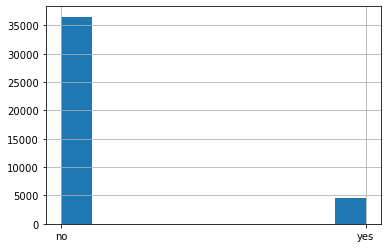

In [37]:
# Target variable
data.y.hist()

In [38]:
data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Clearly, there is a class imbalance with `no` being the majority class and `yes` being the minority class. 

## Solving for Class Imbalance 

Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. 

Since the y variable is imbalanced towards the no responses, we used three diffrent strategies to solve for class imbalance, namely:
1. __Over Sampling__
2. __SMOTE__ 
3. __Under Sampling__ 

Source: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [41]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [42]:
# Over Sampling
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable 
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', y.shape)
print('Resample dataset shape', y_ros.shape)

Original dataset shape (41188,)
Resample dataset shape (73096,)


In [43]:
# Under Sampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

# fit predictor and target variable 
x_rus, y_rus = rus.fit_resample(x, y)

print('Original dataset shape', y.shape)
print('Resample dataset shape', y_rus.shape)

Original dataset shape (41188,)
Resample dataset shape (9280,)


In [48]:
# Label encoding the categorical variables as the SMOTE sampling cannot handle string values.

from sklearn.preprocessing import LabelEncoder

data1 = data.copy()

encoder = LabelEncoder()
for col in categorical_features:
    data1[col] = encoder.fit_transform(data1[col])
    
x = data1.iloc[:, :-1]
y = data1.iloc[:, -1]

In [49]:
# SMOTE Sampling
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable 
x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', y.shape)
print('Resample dataset shape', y_smote.shape)

Original dataset shape (41188,)
Resample dataset shape (73096,)


Going ahead, we would either go ahead with over sampling or SMOTE to build our classification model, based on the performance

In [51]:
y.value_counts()

y_ros.value_counts()

yes    36548
no     36548
Name: y, dtype: int64